In [ ]:
import random
import os
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/borsa_study

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/borsa_study'
/content/gdrive/MyDrive/borsa_study


In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
SYMBOL = "SUMAS.IS"
START_YEAR = 2018
END_YEAR = 2022
# df_symbol = yf.download(SYMBOL, period="max")
# df_symbol.to_csv('sumas2018_2022.csv', encoding='utf-8', index=True)
# df_symbol.head()

In [ ]:
tickers = ['SUMAS.IS','ORMA.IS','YONGA.IS','LBS=F','TRY=X','XU100.IS','XUSIN.IS']

In [ ]:
data_path = 'outputs/fresh_rolling_train/'
data_path_input = 'stock_history/'
example_ticker = 'SUMAS.IS'
file_suffix = '.csv'

In [ ]:
class Stock:
    def __init__(self, dates, prices):
        self.dates = dates
        self.prices = prices

    def __getitem__(self, idx):
        return type(self)(self.dates[idx], self.prices[idx])
    
    def __len__(self):
        return len(self.dates)

    @classmethod
    def read(cls, ticker):
        original = pd.read_csv(data_path_input + ticker + '/' + ticker + file_suffix)
        # print(ticker)
        # original['datetime'] = pd.to_datetime(original['datetime'])
        dates = original['Date'].to_numpy()
        prices = original['Open'].to_numpy()
        print(type(dates))
        return cls(dates, prices)

In [ ]:
stocks = OrderedDict((ticker, Stock.read(ticker)) for ticker in tqdm(tickers))

  0%|          | 0/7 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
def plot(contents, ticker, *args, **kwargs):
    plt.figure(figsize=(12, 8))
    plt.title(f'{ticker.upper()} price')
    contents(ticker, *args, **kwargs)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('price [$]')
    plt.show()

In [ ]:
def plot_price(ticker, **kwargs):
    plt.plot(stocks[ticker].dates, stocks[ticker].prices,
             label='price', c='dodgerblue', zorder=0)

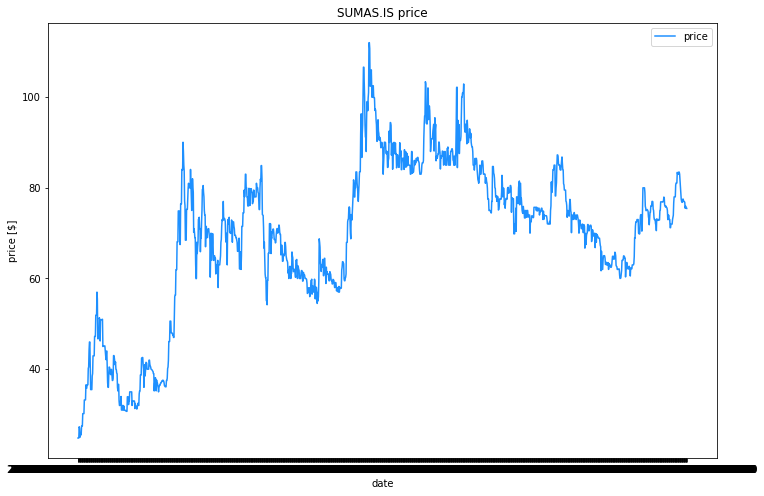

In [ ]:
plot(plot_price, example_ticker)

In [ ]:
def moving_average(signal, period):
    cumsum = np.cumsum(signal)
    result = (cumsum[period:] - cumsum[:-period]) / period
    filler = np.full(period, np.nan)
    return np.concatenate((filler, result))

In [ ]:
def plot_moving_average(ticker, period):
    plot_price(ticker)
    plt.plot(stocks[ticker].dates, moving_average(stocks[ticker].prices, period),
             label=f'{period}-day moving average', c='indigo', zorder=1)

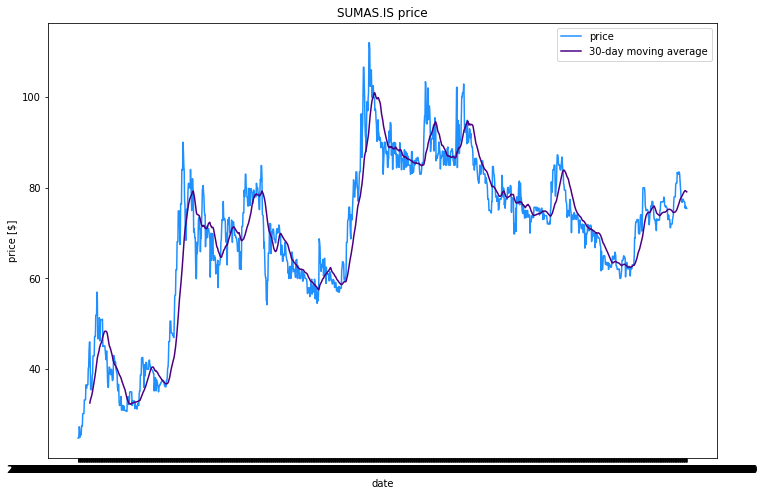

In [ ]:
plot(plot_moving_average, example_ticker, 30)

In [ ]:
def bands(signal, period, power=2, interval=2, log=False):
    if log:
        signal = np.log(signal)
    average = moving_average(signal, period)
    deviation = np.abs(signal - average) ** power
    band_width = moving_average(deviation[period:], period) ** (1/power) * interval
    filler = np.full(period, np.nan)
    filled_width = np.concatenate((filler, band_width))
    low, high = average - filled_width, average + filled_width
    return (np.exp(low), np.exp(high)) if log else (low, high)

In [ ]:
def plot_bands(ticker, period, **bands_kwargs):
    plot_moving_average(ticker, period)
    low_band, high_band = bands(stocks[ticker].prices, period, **bands_kwargs)
    plt.fill_between(stocks[ticker].dates, low_band, high_band,
                     label=f'{period}-day band', color='pink', zorder=-1)

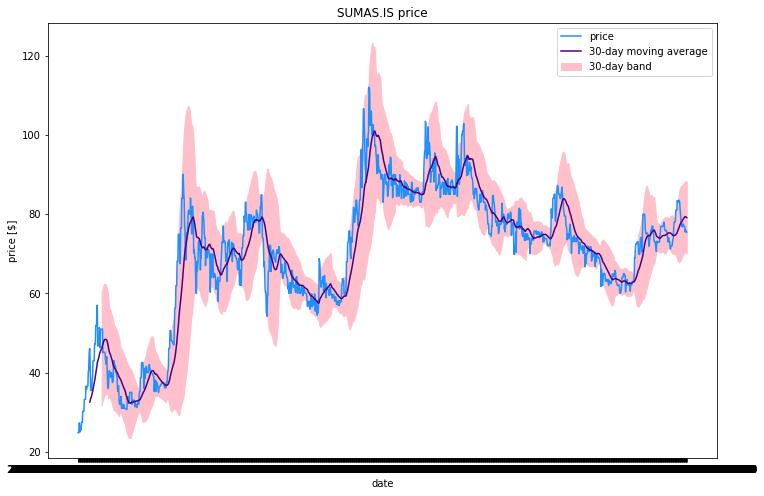

In [ ]:
plot(plot_bands, example_ticker, period=30)

In [ ]:
def keep_strategy(prices):
    '''A baseline trading strategy: buy at the beginning and sell at the end.'''
    return np.array([0]), np.array([len(prices) - 1]) # buys, sells

In [ ]:
def band_strategy(prices, **bands_kwargs):
    '''A trading strategy based on bands: when price falls below bands, buy, when price rises above bands, sell.'''
    low_band, high_band = bands(prices, **bands_kwargs)
    buys = []
    sells = []
    for idx, (price, low, high) in enumerate(zip(prices, low_band, high_band)):
        if price < low and len(buys) <= len(sells):
            buys.append(idx)
        elif price > high and len(buys) > len(sells):
            sells.append(idx)
    return np.array(buys, dtype=int), np.array(sells, dtype=int)

In [ ]:
def gain_strategy(prices, buy_ratio=0.9, sell_ratio=1.1):
    '''
    Start by buying stock.
    Sell when it is worth more than sell_ratio times the buy price.
    Buy again when it is worth less than buy_ratio times the sell price.
    '''
    buys = [0]
    sells = []
    action_price = prices[0] * sell_ratio
    for idx, price in enumerate(prices):
        if len(sells) < len(buys):
            if price >= action_price:
                sells.append(idx)
                action_price = price * buy_ratio
        else:
            if price <= action_price:
                buys.append(idx)
                action_price = price * sell_ratio
    return np.array(buys, dtype=int), np.array(sells, dtype=int)

In [ ]:
def roi(prices, buys, sells):
    if len(sells) < len(buys):
        sells = np.append(sells, -1) # simulate selling at the last price
    return np.prod(prices[sells] / prices[buys]) - 1

In [ ]:
def plot_trades(ticker, background, strategy, **kwargs):
    background(ticker, **kwargs)
    buys, sells = strategy(stocks[ticker].prices, **kwargs)
    roi_value = roi(stocks[ticker].prices, buys, sells)
    plt.title(f'{ticker.upper()} trades using {strategy.__name__}, ROI: {roi_value}')
    plt.scatter(stocks[ticker].dates[buys], stocks[ticker].prices[buys],
                label='buys', marker='x', c='red', s=256, zorder=2)
    plt.scatter(stocks[ticker].dates[sells], stocks[ticker].prices[sells],
                label='sells', marker='x', c='lime', s=256, zorder=2)

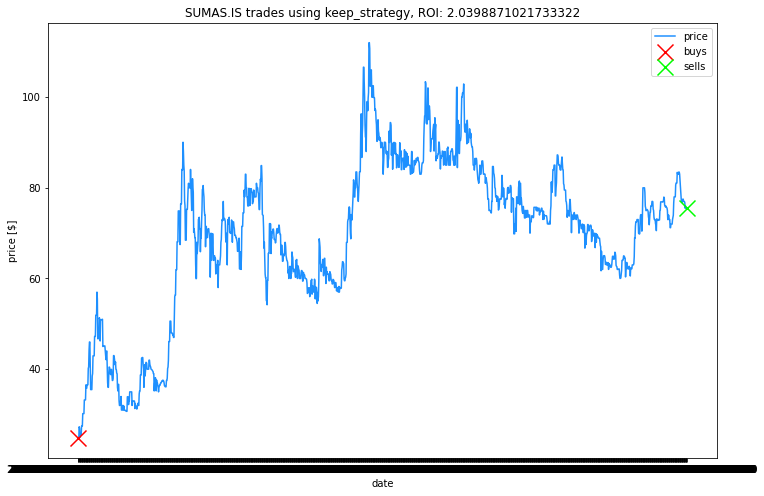

In [ ]:
plot(plot_trades, example_ticker, background=plot_price, strategy=keep_strategy)

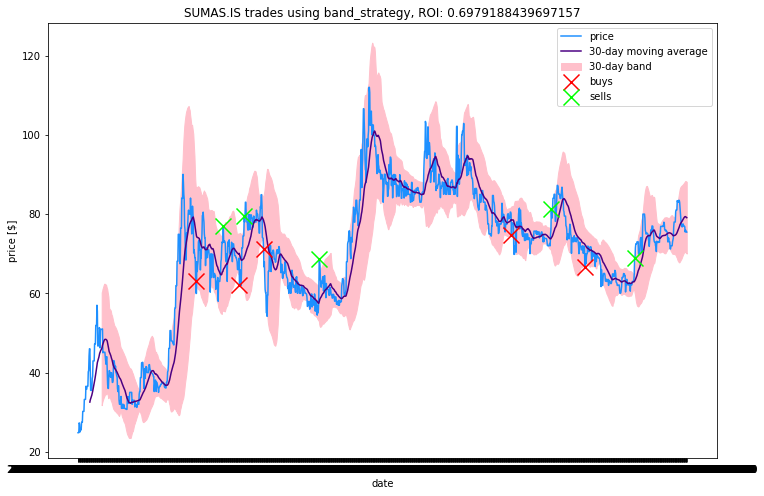

In [ ]:
plot(plot_trades, example_ticker, background=plot_bands, strategy=band_strategy, period=30)

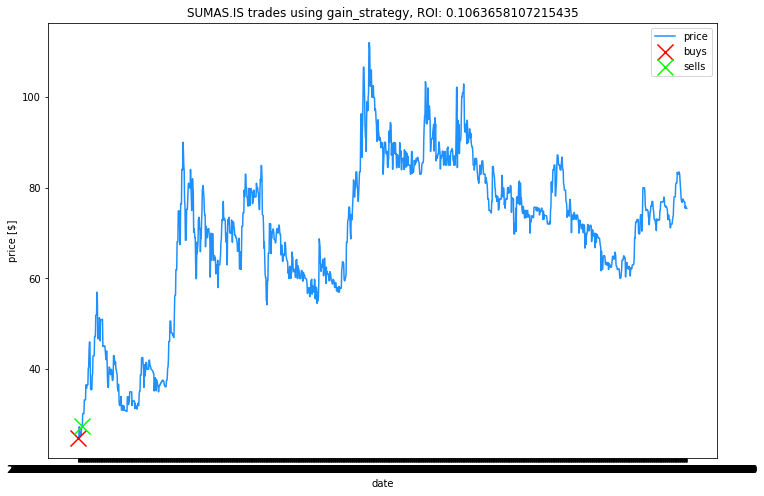

In [ ]:
plot(plot_trades, example_ticker, background=plot_price, strategy=gain_strategy)

In [ ]:
def jumps_ok(prices, max_jump):
    jumps = prices[1:] / prices[:-1]
    return np.max(jumps) <= max_jump and np.max(1/jumps) <= max_jump

def filter_stocks(stocks, start_date=None, end_date=None, min_length=128, min_price=0.01, max_jump=8): 
    masks = {ticker: np.full(len(stocks[ticker]), True) for ticker in stocks}
    if start_date is not None:
      masks = {ticker: np.logical_and(masks[ticker], start_date <=  stocks[ticker].dates.astype("datetime64[ns]")) for ticker in stocks}
    if end_date is not None:
      masks = {ticker: np.logical_and(masks[ticker], stocks[ticker].dates.astype("datetime64[ns]") < end_date) for ticker in stocks}
    filtered = {ticker: stocks[ticker][masks[ticker]] for ticker in stocks}
    filtered = {ticker: filtered[ticker] for ticker in filtered if len(filtered[ticker]) >= min_length}
    filtered = {ticker: filtered[ticker] for ticker in filtered if min(filtered[ticker].prices) >= min_price}
    filtered = {ticker: filtered[ticker] for ticker in filtered if jumps_ok(filtered[ticker].prices, max_jump)}
    return OrderedDict(filtered)

In [ ]:
training = filter_stocks(stocks, end_date=np.datetime64('2022'))
validation = filter_stocks(stocks, start_date=np.datetime64('2022'))
print(f'{len(training)} companies in training, {len(validation)} in validation')

6 companies in training, 7 in validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [ ]:
def strategy_rois(stocks, strategy, **kwargs):
    result = []
    for ticker in stocks:
        buys, sells = strategy(stocks[ticker].prices, **kwargs)
        result.append(roi(stocks[ticker].prices, buys, sells))
    return np.array(result)

def performance(rois, bias=2):
    '''De facto weighted average of ROIs, which gives less weight to very high ones.'''
    return np.exp(np.mean(np.log(rois + bias))) - bias

In [ ]:
def search_params(strategy, num_epochs, param_generator):
    results = []
    for epoch in trange(num_epochs):
        params = param_generator()
        rois = strategy_rois(training, strategy, **params)
        perf = performance(rois)
        results.append({'params': params, 'rois': rois, 'perf': perf})
    return results

In [ ]:
def band_params():
    return {
        'period': int(2 ** np.random.uniform(2, 6)),
        'power': 2 ** np.random.uniform(-2, 2),
        'interval': 2 ** np.random.uniform(0, 1),
        'log': random.choice([True, False])
    }

band_results = search_params(band_strategy, 256, band_params)

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
def gain_params():
    return {
        'buy_ratio': 1 - 2 ** np.random.uniform(-8, -1),
        'sell_ratio': 1 + 2 ** np.random.uniform(-8, -1)
    }

gain_results = search_params(gain_strategy, 256, gain_params)

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
def span_years(dates):
    timespan = np.datetime64(dates[-1]) - np.datetime64(dates[0])
    return timespan / np.timedelta64(1, 'Y').astype(timespan.dtype)

In [ ]:
def roi_hist(strategy, stocks, **kwargs):
    rois = strategy_rois(stocks, strategy, **kwargs)
    print(rois)
    spans = [span_years(stocks[ticker].dates) for ticker in stocks]
    print(spans)
    yearly = [(roi + 1) ** (1/span) - 1 for roi, span in zip(rois, spans)]
    plt.figure(figsize=(12, 8))
    plt.title(f'yearly ROI histogram for {strategy.__name__}')
    print(yearly)
    plt.hist(yearly, bins=np.linspace(np.quantile(yearly, .01), np.quantile(yearly, .99), 256))
    plt.axvline(np.median(yearly), color='orange', label=f'median: {np.median(yearly)}')
    plt.axvline(np.mean(yearly), color='violet', label=f'mean: {np.mean(yearly)}')
    plt.xlabel('yearly ROI')
    plt.ylabel('number of companies')
    plt.legend()
    plt.show()

<built-in method values of collections.OrderedDict object at 0x7f486a159710>
[-0.18870971 -0.00328764  0.03461537 -0.54762743  0.35745085  0.83772526
  0.52287284]
[0.6796283747555848, 0.6796283747555848, 0.6796283747555848, 0.682309242033261, 0.6811513355282222, 0.6798565336728338, 0.6798565336728338]
[-0.26487250042608546, -0.004833660674746443, 0.051345835265895756, -0.6873261921596034, 0.5662194352028824, 1.4475407592454164, 0.8564347463991324]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


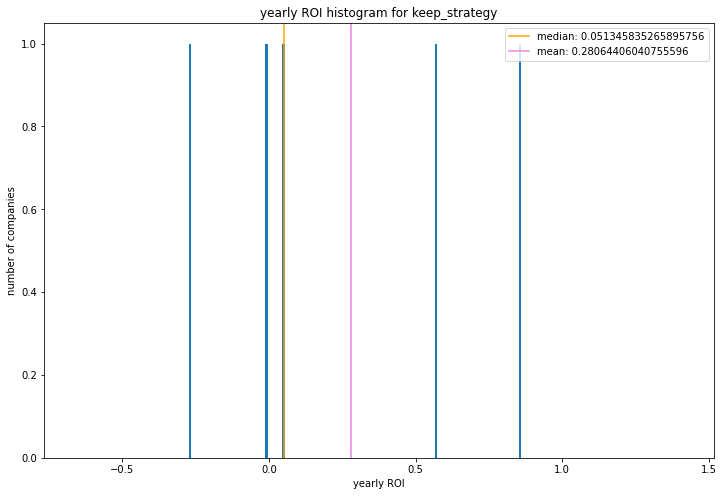

In [ ]:
print(validation.values)
roi_hist(keep_strategy, validation)

In [ ]:
def evaluate_results(search_results, strategy, background_plot):
    best_result = max(search_results, key=lambda result: result['perf'])
    print(f'best params for {strategy.__name__}: {best_result["params"]}')
    roi_hist(strategy, validation, **best_result['params'])
    plot(plot_trades, example_ticker, background=background_plot, strategy=strategy, **best_result['params'])
    return best_result

best params for band_strategy: {'period': 4, 'power': 0.256306938993295, 'interval': 1.009455202383346, 'log': False}
[-9.30235972e-02  9.40296654e-01  1.71460954e+00  7.12001405e-01
  4.69673924e-01  8.06168435e-02 -6.96402358e-04]
[0.6796283747555848, 0.6796283747555848, 0.6796283747555848, 0.682309242033261, 0.6811513355282222, 0.6798565336728338, 0.6798565336728338]
[-0.13382217620372405, 1.6519600339468217, 3.3466404136624934, 1.199005045718204, 0.759938762089921, 0.12079891828751044, -0.0010241692499725064]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


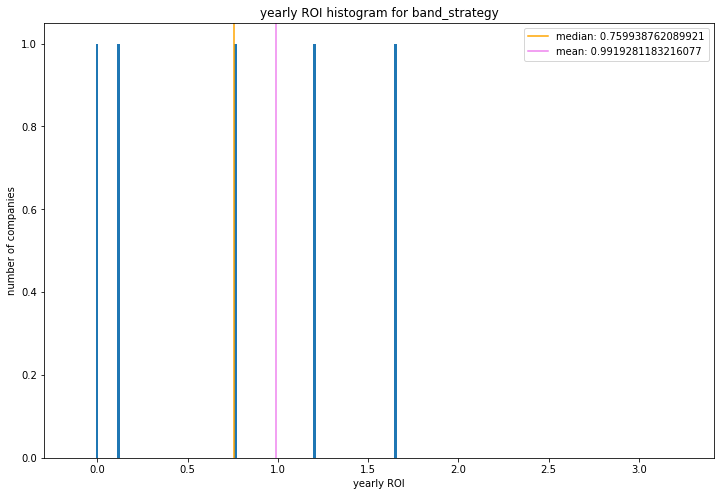

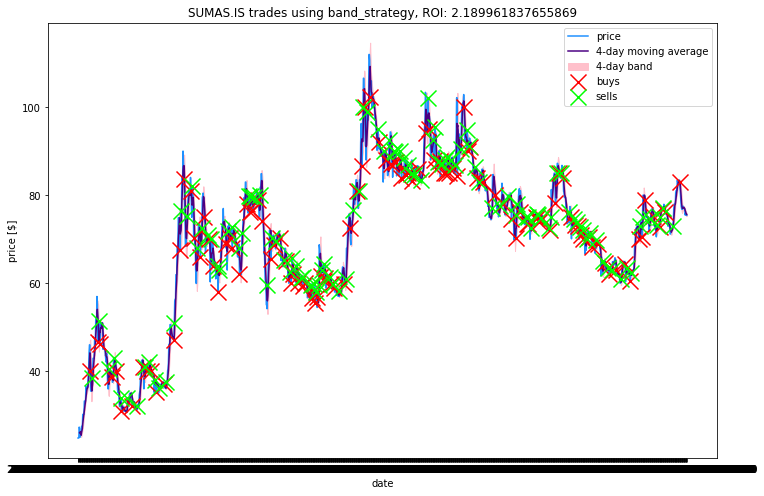

In [ ]:
best_band = evaluate_results(band_results, band_strategy, plot_bands)

best params for gain_strategy: {'buy_ratio': 0.9929214654459512, 'sell_ratio': 1.0888039508461382}
[-0.18870971  0.02123422  0.03461537 -0.53073595  0.09124719  0.20080264
  0.19000855]
[0.6796283747555848, 0.6796283747555848, 0.6796283747555848, 0.682309242033261, 0.6811513355282222, 0.6798565336728338, 0.6798565336728338]
[-0.26487250042608546, 0.03139965450710491, 0.051345835265895756, -0.6700671786734669, 0.13677642357969155, 0.30886457883387153, 0.29159545179070734]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


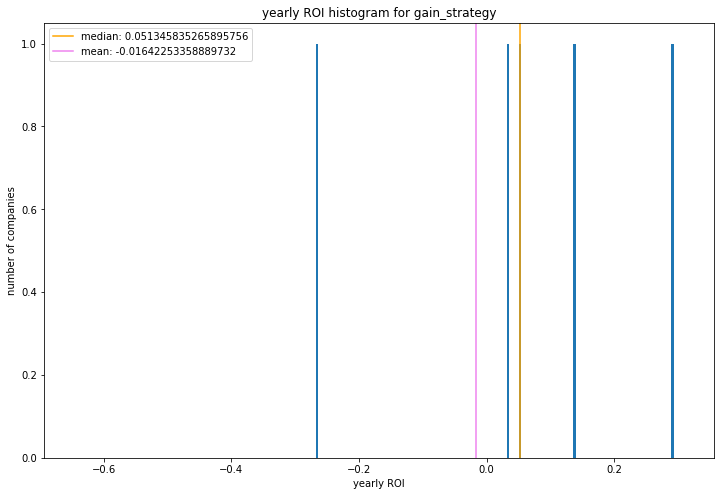

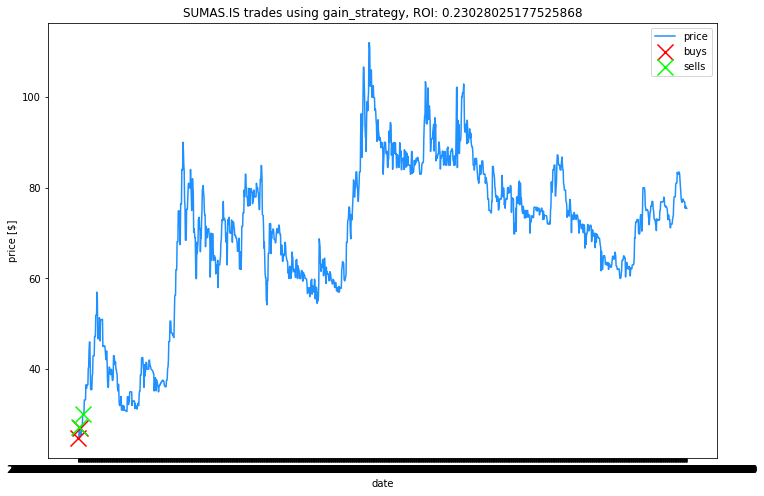

In [ ]:
best_gain = evaluate_results(gain_results, gain_strategy, plot_price)

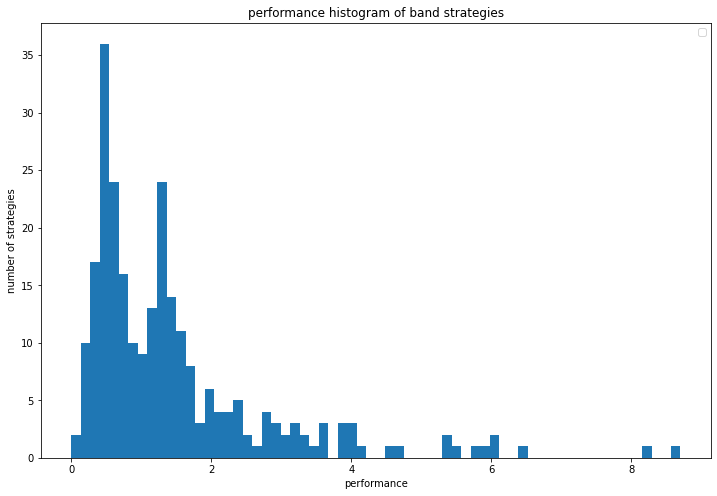

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('performance histogram of band strategies')
plt.xlabel('performance')
plt.ylabel('number of strategies')
plt.hist([result['perf'] for result in band_results], bins=64)
plt.legend()
plt.show()

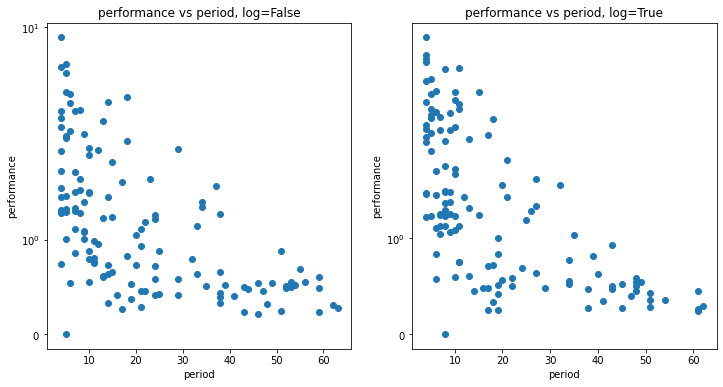

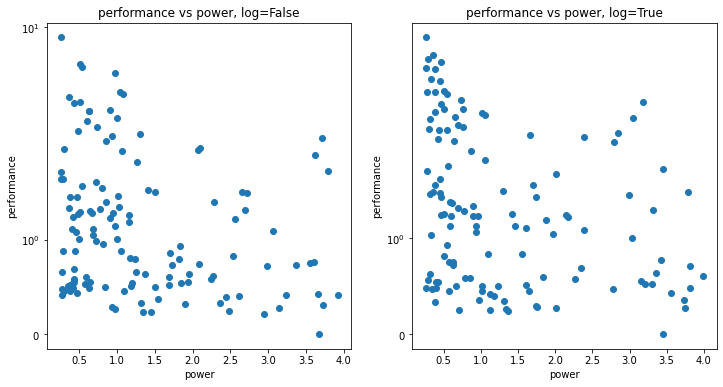

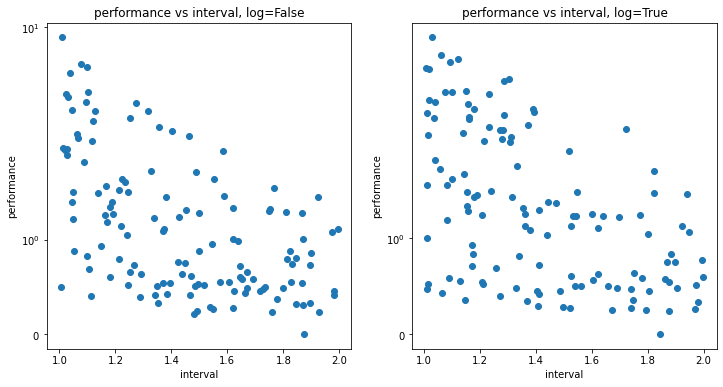

In [ ]:
for param_name in ['period', 'power', 'interval']:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for idx, ax in enumerate(axes):
        log = bool(idx)
        ax.set_title(f'performance vs {param_name}, log={log}')
        ax.set_xlabel(f'{param_name}')
        ax.set_ylabel('performance')
        ax.set_yscale('symlog')
        fitting_log = [result for result in band_results if result['params']['log'] == log]
        ax.scatter(
            [result['params'][param_name] for result in fitting_log],
            [result['perf'] for result in fitting_log]
        )
    plt.show()

  0%|          | 0/256 [00:00<?, ?it/s]

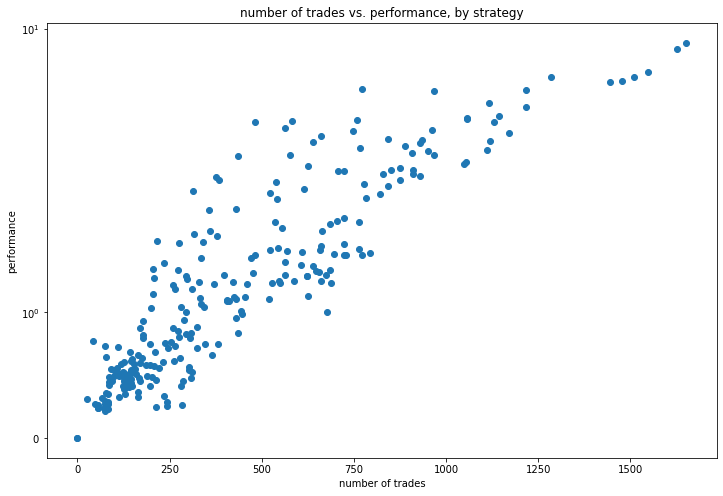

In [ ]:
def trade_count(strategy, stocks, **kwargs):
    return sum(len(np.concatenate(strategy(stocks[ticker].prices, **kwargs))) for ticker in stocks)

plt.figure(figsize=(12, 8))
plt.title('number of trades vs. performance, by strategy')
plt.xlabel('number of trades')
plt.ylabel('performance')
plt.yscale('symlog')
plt.scatter(
    [trade_count(band_strategy, validation, **result['params']) for result in tqdm(band_results)],
    [result['perf'] for result in band_results]
)
plt.show()

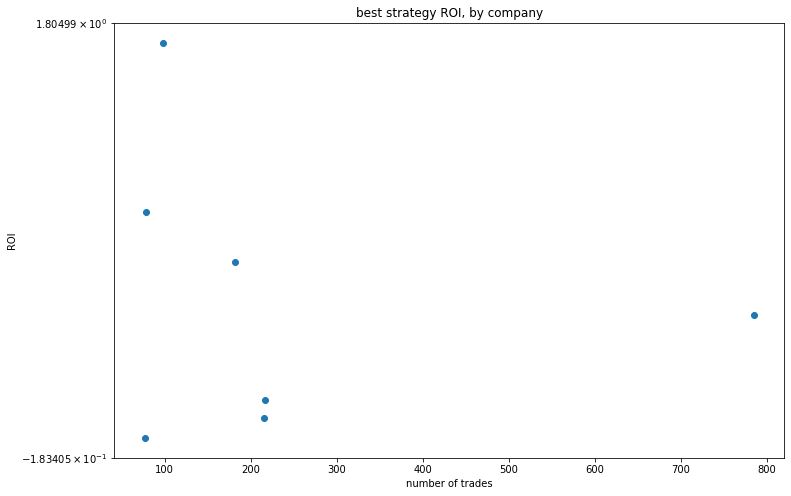

In [ ]:
best_band_trades = {ticker: band_strategy(validation[ticker].prices, **best_band['params']) for ticker in validation}

plt.figure(figsize=(12, 8))
plt.title('best strategy ROI, by company')
plt.xlabel('number of trades')
plt.ylabel('ROI')
plt.yscale('symlog')
plt.scatter(
    [len(np.concatenate(best_band_trades[ticker])) for ticker in validation],
    [roi(validation[ticker].prices, *best_band_trades[ticker]) for ticker in validation]
)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.


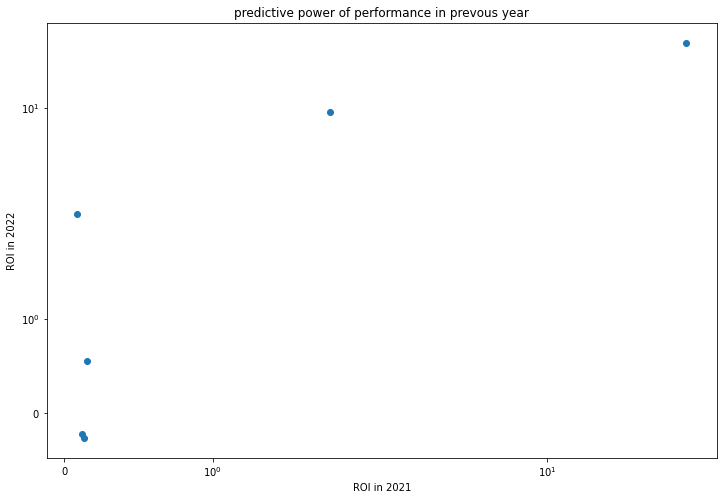

In [ ]:
validation_2021 = filter_stocks(
    stocks,
    start_date=np.datetime64('2020'),
    end_date=np.datetime64('2021'),
    min_length=best_band['params']['period'] * 2
)
validation_2022 = filter_stocks(
    stocks,
    start_date=np.datetime64('2021'),
    end_date=np.datetime64('2022'),
    min_length=best_band['params']['period'] * 2
)
# filter so that only companies in both are kept, arrange in the same order
validation_2021 = OrderedDict((ticker, validation_2021[ticker]) for ticker in validation_2021 if ticker in validation_2022)
validation_2022 = OrderedDict((ticker, validation_2022[ticker]) for ticker in validation_2021 if ticker in validation_2021)

rois_2021 = strategy_rois(validation_2021, band_strategy, **best_band['params'])
rois_2022 = strategy_rois(validation_2022, band_strategy, **best_band['params'])

plt.figure(figsize=(12, 8))
plt.title('predictive power of performance in prevous year')
plt.xlabel('ROI in 2021')
plt.xscale('symlog')
plt.ylabel('ROI in 2022')
plt.yscale('symlog')
plt.scatter(rois_2021, rois_2022)
plt.show()

In [ ]:
def roi_by_step(prices, strategy, **kwargs):
    buys, sells = strategy(prices, **kwargs)
    buy_mask = np.full(len(prices), False)
    buy_mask[buys] = True
    sell_mask = np.full(len(prices), False)
    sell_mask[sells] = True
    last_sell_ratio = 1.0
    owned = False
    ratios = []
    for price, is_buy, is_sell in zip(prices, buy_mask, sell_mask):
        if is_buy:
            owned = True
            buy_price = price
        elif is_sell:
            owned = False
            last_sell_ratio = price / buy_price * last_sell_ratio
        if owned:
            ratios.append(price / buy_price * last_sell_ratio)
        else:
            ratios.append(last_sell_ratio)
    return np.array(ratios) - 1

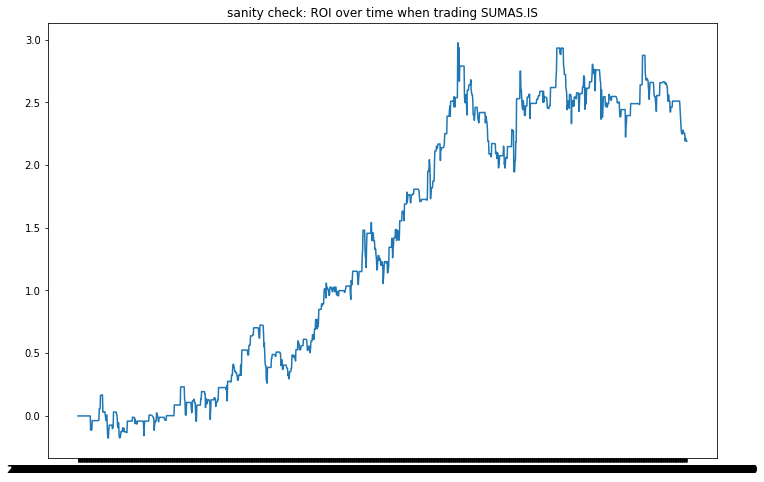

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'sanity check: ROI over time when trading {example_ticker.upper()}')
plt.plot(
    stocks[example_ticker].dates,
    roi_by_step(stocks[example_ticker].prices, band_strategy, **best_band['params'])
)
plt.show()

AttributeError: ignored

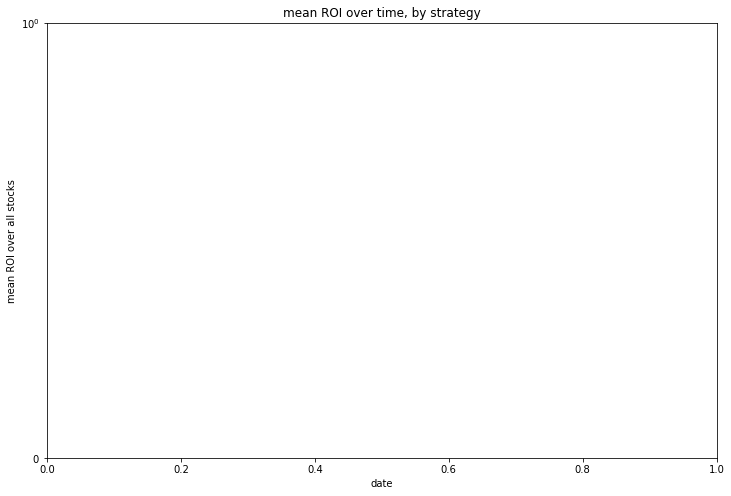

In [ ]:
def mean_roi_by_date(stocks, strategy, **kwargs):
    min_date = min(np.min(stocks[ticker].dates) for ticker in stocks)
    max_date = max(np.max(stocks[ticker].dates) for ticker in stocks)
    span_days = int((np.datetime64(max_date) - np.datetime64(min_date)).astype(int))
    all_dates = [np.datetime64(min_date) + np.timedelta64(i, 'D') for i in range(span_days + 1)]
    
    aggregator = OrderedDict((date, {}) for date in all_dates)
    for ticker in tqdm(stocks):
        rois = roi_by_step(stocks[ticker].prices, strategy, **kwargs)
        for date, roi in zip(stocks[ticker].dates, rois):
            aggregator[date][ticker] = roi
    
    # fill missing values with last available value
    last_value = {ticker: 0.0 for ticker in stocks}
    for date in aggregator:
        for ticker in stocks:
            if ticker not in aggregator[date]:
                aggregator[date][ticker] = last_value[ticker]
            else:
                last_value[ticker] = aggregator[date][ticker]
    
    return all_dates, [np.mean([aggregator[date][ticker] for ticker in stocks]) for date in aggregator]


plt.figure(figsize=(12, 8))
plt.title('mean ROI over time, by strategy')
plt.xlabel('date')
plt.ylabel('mean ROI over all stocks')
plt.yscale('symlog')
plt.plot(*mean_roi_by_date(validation, keep_strategy), label='keep')
plt.plot(*mean_roi_by_date(validation, band_strategy, **best_band['params']), label='band')
plt.plot(*mean_roi_by_date(validation, gain_strategy, **best_gain['params']), label='gain')
plt.legend()
plt.show()

In [ ]:
"""
import talib as ta
# exponential moving average
df['EMA10'] = ta.EMA(df.close, 10)
df['EMA50'] = ta.EMA(df.close, 50)
# relative strength indicator (tells if an asset is overbought or oversold)
df['RSI28'] = ta.RSI(df.close, 28)
# bollinger bands (lower and upper bands 2 standard deviation off the current price, based off a set rolling window)
_, _, df['BBANDS_LOW'] = ta.BBANDS(df.close)  # use default parameters for Bollinger Bands
"""

In [ ]:
# daily return
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].plot(linestyle='--', marker='o')
    plt.ylabel(None)
    plt.xlabel(None)
    plt.title(f"Daily Return of {tech_list[i - 1]}")
    
plt.tight_layout()

sns.heatmap(data=closing_df.dropna().corr(), annot=True)